In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble.forest import _generate_sample_indices

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

from tqdm import tqdm_notebook as tqdm

from joblib import Parallel, delayed

In [2]:
def generate_2d_rotation(theta=0, acorn=None):
    if acorn is not None:
        np.random.seed(acorn)
    
    R = np.array([
        [np.cos(theta), np.sin(theta)],
        [-np.sin(theta), np.cos(theta)]
    ])
    
    return R

def generate_gaussian_parity(n, mean=np.array([-1, -1]), cov_scale=1, angle_params=None, k=1, acorn=None):
    if acorn is not None:
        np.random.seed(acorn)
        
    d = len(mean)
    
    if mean[0] == -1 and mean[1] == -1:
        mean = mean + 1 / 2**k
    
    mnt = np.random.multinomial(n, 1/(4**k) * np.ones(4**k))
    cumsum = np.cumsum(mnt)
    cumsum = np.concatenate(([0], cumsum))
    
    Y = np.zeros(n)
    X = np.zeros((n, d))
    
    for i in range(2**k):
        for j in range(2**k):
            temp = np.random.multivariate_normal(mean, cov_scale * np.eye(d), 
                                                 size=mnt[i*(2**k) + j])
            temp[:, 0] += i*(1/2**(k-1))
            temp[:, 1] += j*(1/2**(k-1))
            
            X[cumsum[i*(2**k) + j]:cumsum[i*(2**k) + j + 1]] = temp
            
            if i % 2 == j % 2:
                Y[cumsum[i*(2**k) + j]:cumsum[i*(2**k) + j + 1]] = 0
            else:
                Y[cumsum[i*(2**k) + j]:cumsum[i*(2**k) + j + 1]] = 1
                
    if d == 2:
        if angle_params is None:
            angle_params = np.random.uniform(0, 2*np.pi)
            
        R = generate_2d_rotation(angle_params)
        X = X @ R
        
    else:
        raise ValueError('d=%i not implemented!'%(d))
       
    return X, Y.astype(int)

def get_colors(colors, inds):
    c = [colors[i] for i in inds]
    return c

In [3]:
n_mc = 50 # number of simulation repititions

n_xor = (100*np.arange(0.5, 2.25, step=0.25)).astype(int)
n_nxor = (100*np.arange(0.5, 10.25, step=0.25)).astype(int) # number of training samples 

m = 1000 # number of test samples each monte carlo iteration

nR=30

d = 2

n1s = n_xor
n2s = n_nxor

ns = np.concatenate((n1s, n2s + n1s[-1]))

ls=['-', '--']

# (XOR, N-XOR)

# Paper fig 1

In [38]:
import pickle 

TASK1='XOR'
TASK2='N-XOR'
mean_error_xor_nxor = pickle.load(open('data/gaussian-lifelong-experiments/mean_error_%s_%s_nmc%i_nD%i_n1%ito%i_n2%ito%i_d%i_m%i.pkl'%(TASK1, TASK2,
                                                                                                   n_mc, nR, n_xor[0],
                                                                                                   n_xor[-1], n_nxor[0],
                                                                                                   n_nxor[-1], d, m), 
                                      'rb'))

std_error_xor_nxor = pickle.load(open('data/gaussian-lifelong-experiments/std_error_%s_%s_nmc%i_nD%i_n1%ito%i_n2%ito%i_d%i_m%i.pkl'%(TASK1, TASK2,
                                                                                                   n_mc, nR, n_xor[0],
                                                                                                   n_xor[-1], n_nxor[0],
                                                                                                   n_nxor[-1], d, m), 
                                      'rb'))

mean_te_xor_nxor = pickle.load(open('data/gaussian-lifelong-experiments/mean_te_%s_%s_nmc%i_nD%i_n1%ito%i_n2%ito%i_d%i_m%i.pkl'%(TASK1, TASK2,
                                                                                                   n_mc, nR, n_xor[0],
                                                                                                   n_xor[-1], n_nxor[0],
                                                                                                   n_nxor[-1], d, m), 
                                      'rb'))

std_te_xor_nxor = pickle.load(open('data/gaussian-lifelong-experiments/std_te_%s_%s_nmc%i_nD%i_n1%ito%i_n2%ito%i_d%i_m%i.pkl'%(TASK1, TASK2,
                                                                                                   n_mc, nR, n_xor[0],
                                                                                                   n_xor[-1], n_nxor[0],
                                                                                                   n_nxor[-1], d, m), 
                                      'rb'))

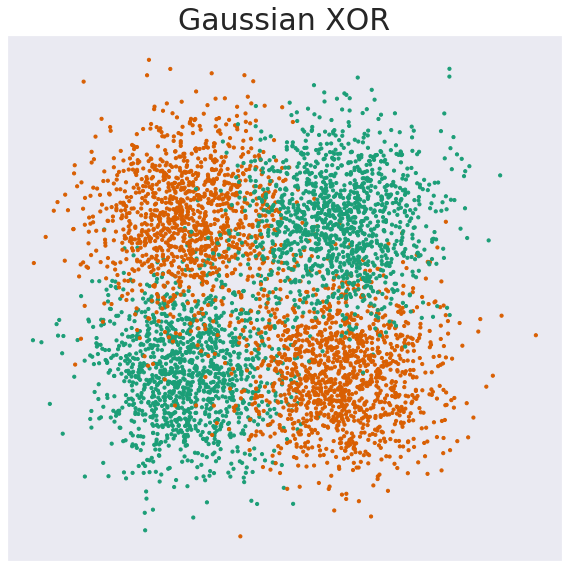

In [48]:
colors = sns.color_palette('Dark2', n_colors=2)

X, Y = generate_gaussian_parity(5000, cov_scale=0.1, angle_params=0)
Z, W = generate_gaussian_parity(5000, cov_scale=0.1, angle_params=np.pi/2)

fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.scatter(X[:, 0], X[:, 1], c=get_colors(colors, Y), s=10)

ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Gaussian XOR', fontsize=30)

# ax.set_aspect('equal')

plt.tight_layout()
plt.savefig('figures/gaussian-lifelong-experiments/gaussian-xor.pdf')

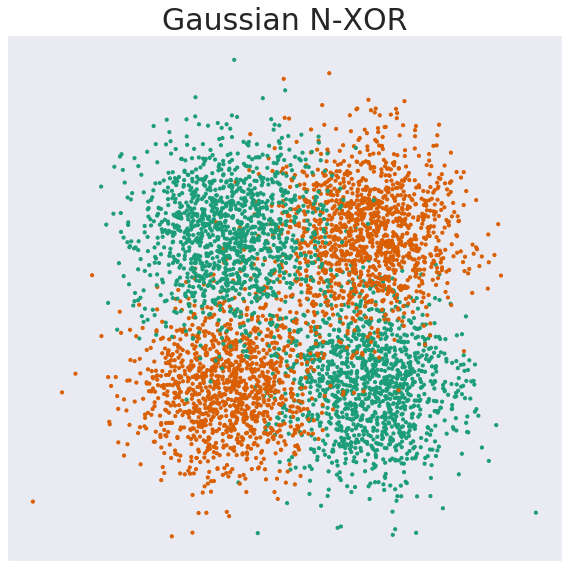

In [49]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.scatter(Z[:, 0], Z[:, 1], c=get_colors(colors, W), s=10)

ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Gaussian N-XOR', fontsize=30)

plt.tight_layout()
plt.savefig('figures/gaussian-lifelong-experiments/gaussian-nxor.pdf')

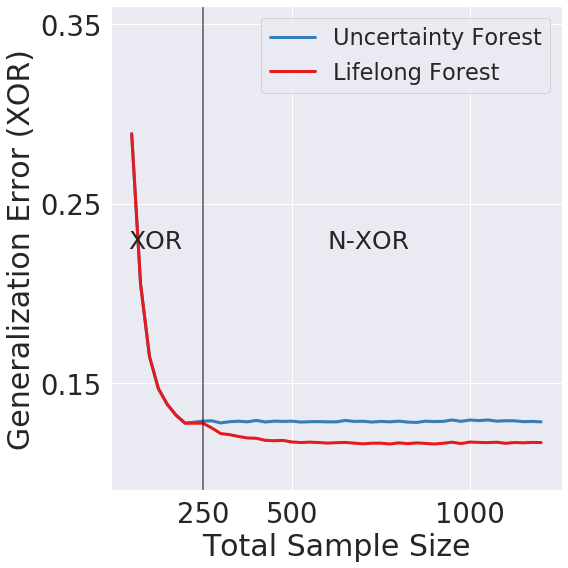

In [39]:
mean_error = mean_error_xor_nxor
std_error = std_error_xor_nxor / np.sqrt(n_mc)

TASK1='XOR'
TASK2='N-XOR'

algorithms = ['Uncertainty Forest', 'Lifelong Forest']

fontsize=30
labelsize=27.5

colors = sns.color_palette("Set1", n_colors = 2)

fig1 = plt.figure(figsize=(8,8))
ax1 = fig1.add_subplot(1,1,1)
# for i, algo in enumerate(algorithms):
ax1.plot(ns, mean_error[0], label=algorithms[0], c=colors[1], ls=ls[np.sum(0 > 1).astype(int)], lw=3)
ax1.fill_between(ns, 
        mean_error[0] + 1.96*std_error[0], 
        mean_error[0] - 1.96*std_error[0], 
        where=mean_error[0] + 1.96*std_error[0] >= mean_error[0] - 1.96*std_error[0], 
        facecolor=colors[1], 
        alpha=0.15,
        interpolate=True)

ax1.plot(ns, mean_error[1], label=algorithms[1], c=colors[0], ls=ls[np.sum(1 > 1).astype(int)], lw=3)
ax1.fill_between(ns, 
        mean_error[1] + 1.96*std_error[1, ], 
        mean_error[1] - 1.96*std_error[1, ], 
        where=mean_error[1] + 1.96*std_error[1] >= mean_error[1] - 1.96*std_error[1], 
        facecolor=colors[0], 
        alpha=0.15,
        interpolate=True)

ax1.set_ylabel('Generalization Error (%s)'%(TASK1), fontsize=fontsize)
ax1.legend(loc='upper right', fontsize=22.5)
#         ax1.set_ylim(-0.01, 0.22)
ax1.set_xlabel('Total Sample Size', fontsize=fontsize)
ax1.tick_params(labelsize=labelsize)
ax1.set_yticks([0.15, 0.25, 0.35])
ax1.set_xticks([250, 500, 1000])
ax1.axvline(x=ns[len(n1s)], c='k', alpha=0.75)

ax1.set_ylim(0.09, 0.36)

ax1.text(40, np.mean(ax1.get_ylim()), "%s"%(TASK1), fontsize=25)
ax1.text(600, np.mean(ax1.get_ylim()), "%s"%(TASK2), fontsize=25)

plt.tight_layout()

plt.savefig('figures/gaussian-lifelong-experiments/lifelong_experiment_ge_xor_%s_%s_nmc%i_nD%i_n1%ito%i_n2%ito%i_d%i_m%i.pdf'%(TASK1, TASK2,
                                                                                                   n_mc, nR, n_xor[0],
                                                                                                   n_xor[-1], n_nxor[0],
                                                                                                   n_nxor[-1], d, m))

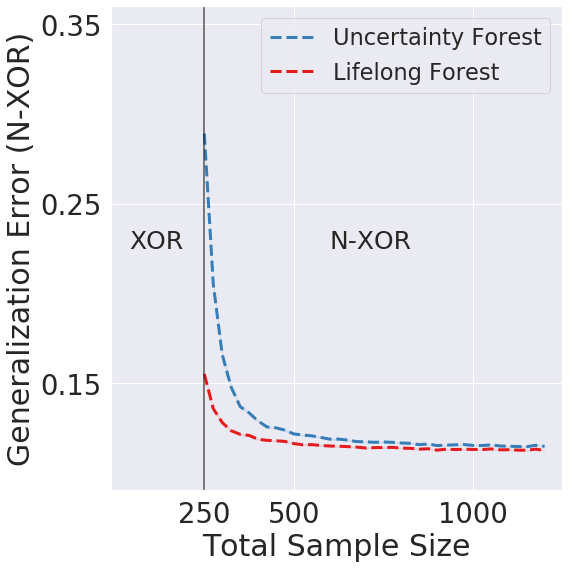

In [40]:
mean_error = mean_error_xor_nxor
std_error = std_error_xor_nxor / np.sqrt(n_mc)

algorithms = ['Uncertainty Forest', 'Lifelong Forest']

TASK1='XOR'
TASK2='N-XOR'

fig1 = plt.figure(figsize=(8,8))
ax1 = fig1.add_subplot(1,1,1)
# for i, algo in enumerate(algorithms):
ax1.plot(ns[len(n1s):], mean_error[2, len(n1s):], label=algorithms[0], c=colors[1], ls=ls[1], lw=3)
ax1.fill_between(ns[len(n1s):], 
        mean_error[2, len(n1s):] + 1.96*std_error[2, len(n1s):], 
        mean_error[2, len(n1s):] - 1.96*std_error[2, len(n1s):], 
        where=mean_error[2, len(n1s):] + 1.96*std_error[2, len(n1s):] >= mean_error[2, len(n1s):] - 1.96*std_error[2, len(n1s):], 
        facecolor=colors[1], 
        alpha=0.15,
        interpolate=True)

ax1.plot(ns[len(n1s):], mean_error[3, len(n1s):], label=algorithms[1], c=colors[0], ls=ls[1], lw=3)
ax1.fill_between(ns[len(n1s):], 
        mean_error[3, len(n1s):] + 1.96*std_error[3, len(n1s):], 
        mean_error[3, len(n1s):] - 1.96*std_error[3, len(n1s):], 
        where=mean_error[3, len(n1s):] + 1.96*std_error[3, len(n1s):] >= mean_error[3, len(n1s):] - 1.96*std_error[3, len(n1s):], 
        facecolor=colors[0], 
        alpha=0.15,
        interpolate=True)

ax1.set_ylabel('Generalization Error (%s)'%(TASK2), fontsize=fontsize)
ax1.legend(loc='upper right', fontsize=22.5)
#         ax1.set_ylim(-0.01, 0.22)
ax1.set_xlabel('Total Sample Size', fontsize=fontsize)
ax1.tick_params(labelsize=labelsize)
# ax1.set_yticks([0.15, 0.25, 0.35])
ax1.set_yticks([0.15, 0.25, 0.35])
ax1.set_xticks([250, 500, 1000])
ax1.axvline(x=ns[len(n1s)], c='k', alpha=0.75)

ax1.set_ylim(0.09, 0.36)

ax1.set_xlim(-10)
# ax1.set_ylim(0.14, 0.36)
ax1.text(40, np.mean(ax1.get_ylim()), "%s"%(TASK1), fontsize=25)
ax1.text(600, np.mean(ax1.get_ylim()), "%s"%(TASK2), fontsize=25)

plt.tight_layout()

plt.savefig('figures/gaussian-lifelong-experiments/lifelong_experiment_ge_nxor_%s_%s_nmc%i_nD%i_n1%ito%i_n2%ito%i_d%i_m%i.pdf'%(TASK1, TASK2,
                                                                                                   n_mc, nR, n_xor[0],
                                                                                                   n_xor[-1], n_nxor[0],
                                                                                                   n_nxor[-1], d, m))

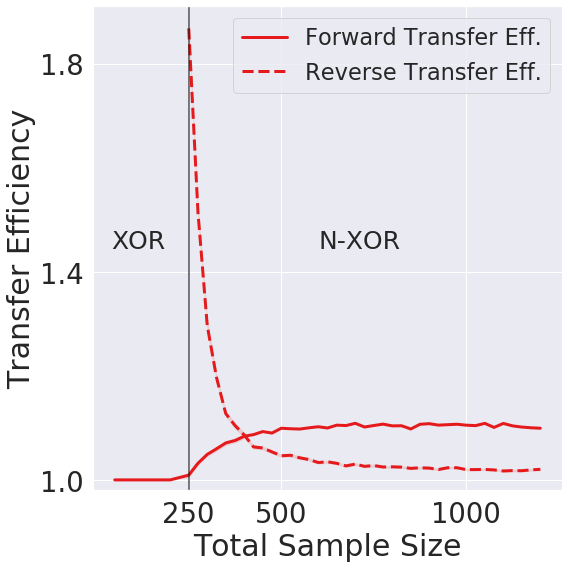

In [41]:
mean_error = mean_te_xor_nxor
std_error = std_te_xor_nxor / np.sqrt(n_mc)

algorithms = ['Forward Transfer Eff.', 'Reverse Transfer Eff.']

TASK1='XOR'
TASK2='N-XOR'

fig1 = plt.figure(figsize=(8,8))
ax1 = fig1.add_subplot(1,1,1)

ax1.plot(ns, mean_error[0], label=algorithms[0], c=colors[0], ls=ls[0], lw=3)
ax1.fill_between(ns, 
        mean_error[0] + 1.96*std_error[0], 
        mean_error[0] - 1.96*std_error[0], 
        where=mean_error[1] + 1.96*std_error[0] >= mean_error[0] - 1.96*std_error[0], 
        facecolor=colors[0], 
        alpha=0.15,
        interpolate=True)

ax1.plot(ns[len(n1s):], mean_error[1, len(n1s):], label=algorithms[1], c=colors[0], ls=ls[1], lw=3)
ax1.fill_between(ns[len(n1s):], 
        mean_error[1, len(n1s):] + 1.96*std_error[1, len(n1s):], 
        mean_error[1, len(n1s):] - 1.96*std_error[1, len(n1s):], 
        where=mean_error[1, len(n1s):] + 1.96*std_error[1, len(n1s):] >= mean_error[1, len(n1s):] - 1.96*std_error[1, len(n1s):], 
        facecolor=colors[0], 
        alpha=0.15,
        interpolate=True)

ax1.set_ylabel('Transfer Efficiency', fontsize=fontsize)
ax1.legend(loc='upper right', fontsize=22.5)
ax1.set_ylim(0.98, 1.91)
ax1.set_xlabel('Total Sample Size', fontsize=fontsize)
ax1.tick_params(labelsize=labelsize)
ax1.set_yticks([1, 1.4, 1.8])
ax1.set_xticks([250, 500, 1000])
ax1.axvline(x=ns[len(n1s)], c='k', alpha=0.75)

ax1.text(40, np.mean(ax1.get_ylim()), "%s"%(TASK1), fontsize=25)
ax1.text(600, np.mean(ax1.get_ylim()), "%s"%(TASK2), fontsize=25)

plt.tight_layout()

plt.savefig('figures/gaussian-lifelong-experiments/lifelong_experiment_te_%s_%s_nmc%i_nD%i_n1%ito%i_n2%ito%i_d%i_m%i.pdf'%(TASK1, TASK2,
                                                                                                   n_mc, nR, n_xor[0],
                                                                                                   n_xor[-1], n_nxor[0],
                                                                                                   n_nxor[-1], d, m))

# (XOR, R-XOR)

In [26]:
TASK1='XOR'
TASK2='R-XOR'
mean_error_xor_rxor = pickle.load(open('data/gaussian-lifelong-experiments/mean_error_%s_%s_nmc%i_nD%i_n1%ito%i_n2%ito%i_d%i_m%i.pkl'%(TASK1, TASK2,
                                                                                                   n_mc, nR, n_xor[0],
                                                                                                   n_xor[-1], n_nxor[0],
                                                                                                   n_nxor[-1], d, m), 
                                      'rb'))

std_error_xor_rxor = pickle.load(open('data/gaussian-lifelong-experiments/std_error_%s_%s_nmc%i_nD%i_n1%ito%i_n2%ito%i_d%i_m%i.pkl'%(TASK1, TASK2,
                                                                                                   n_mc, nR, n_xor[0],
                                                                                                   n_xor[-1], n_nxor[0],
                                                                                                   n_nxor[-1], d, m), 
                                      'rb'))

mean_te_xor_rxor = pickle.load(open('data/gaussian-lifelong-experiments/mean_te_%s_%s_nmc%i_nD%i_n1%ito%i_n2%ito%i_d%i_m%i.pkl'%(TASK1, TASK2,
                                                                                                   n_mc, nR, n_xor[0],
                                                                                                   n_xor[-1], n_nxor[0],
                                                                                                   n_nxor[-1], d, m), 
                                      'rb'))

std_te_xor_rxor = pickle.load(open('data/gaussian-lifelong-experiments/std_te_%s_%s_nmc%i_nD%i_n1%ito%i_n2%ito%i_d%i_m%i.pkl'%(TASK1, TASK2,
                                                                                                   n_mc, nR, n_xor[0],
                                                                                                   n_xor[-1], n_nxor[0],
                                                                                                   n_nxor[-1], d, m), 
                                      'rb'))

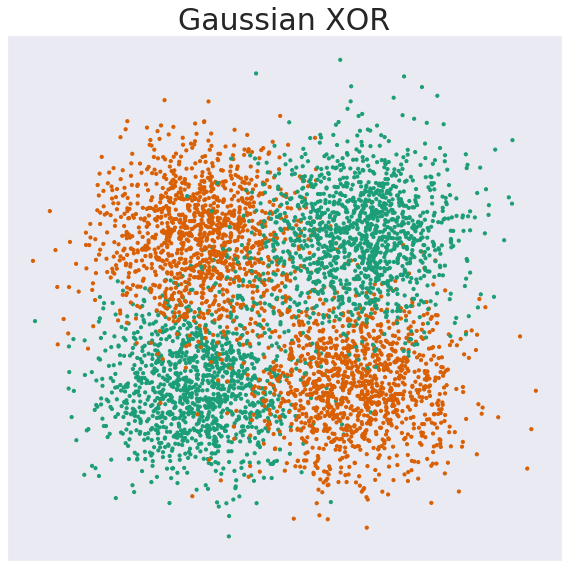

In [27]:
colors = sns.color_palette('Dark2', n_colors=2)

X, Y = generate_gaussian_parity(5000, cov_scale=0.1, angle_params=0)
Z, W = generate_gaussian_parity(5000, cov_scale=0.1, angle_params=np.pi/4)

fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.scatter(X[:, 0], X[:, 1], c=get_colors(colors, Y), s=10)

ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Gaussian XOR', fontsize=30)

plt.tight_layout()
plt.savefig('figures/gaussian-lifelong-experiments/gaussian-xor.pdf')

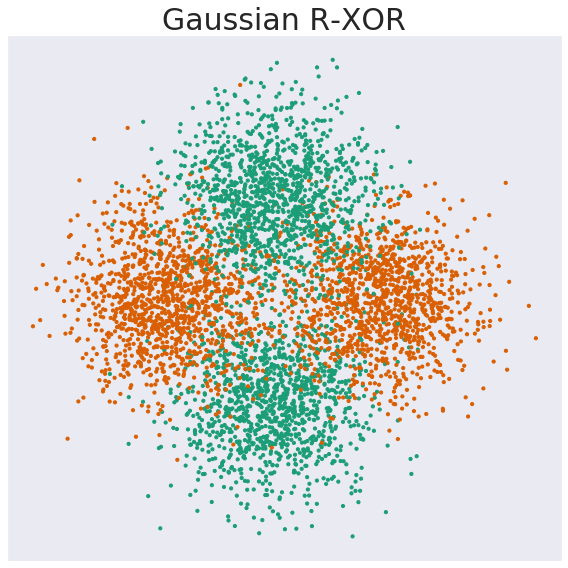

In [28]:
colors = sns.color_palette('Dark2', n_colors=2)
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.scatter(Z[:, 0], Z[:, 1], c=get_colors(colors, W), s=10)

ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Gaussian R-XOR', fontsize=30)

plt.tight_layout()
plt.savefig('figures/gaussian-lifelong-experiments/gaussian-rxor.pdf')

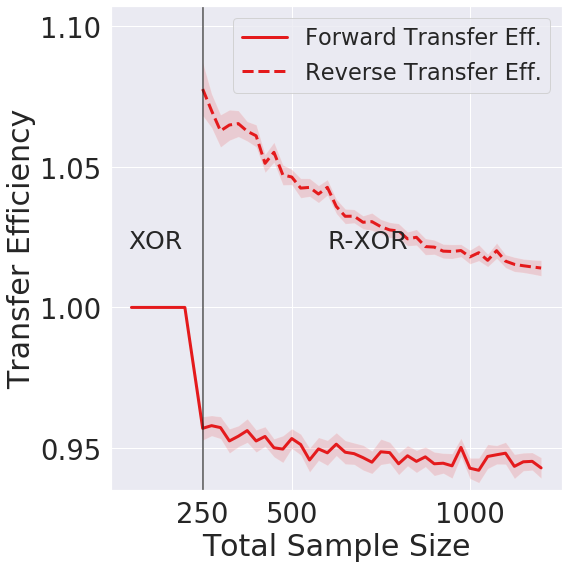

In [42]:
mean_error = mean_te_xor_rxor
std_error = std_te_xor_rxor / np.sqrt(n_mc)

TASK1='XOR'
TASK2='R-XOR'

colors = sns.color_palette("Set1", n_colors = 2)

fig1 = plt.figure(figsize=(8,8))
ax1 = fig1.add_subplot(1,1,1)

ax1.plot(ns, mean_error[0], label=algorithms[0], c=colors[0], ls=ls[0], lw=3)
ax1.fill_between(ns, 
        mean_error[0] + 1.96*std_error[0], 
        mean_error[0] - 1.96*std_error[0], 
        where=mean_error[1] + 1.96*std_error[0] >= mean_error[0] - 1.96*std_error[0], 
        facecolor=colors[0], 
        alpha=0.15,
        interpolate=True)

ax1.plot(ns[len(n1s):], mean_error[1, len(n1s):], label=algorithms[1], c=colors[0], ls=ls[1], lw=3)
ax1.fill_between(ns[len(n1s):], 
        mean_error[1, len(n1s):] + 1.96*std_error[1, len(n1s):], 
        mean_error[1, len(n1s):] - 1.96*std_error[1, len(n1s):], 
        where=mean_error[1, len(n1s):] + 1.96*std_error[1, len(n1s):] >= mean_error[1, len(n1s):] - 1.96*std_error[1, len(n1s):], 
        facecolor=colors[0], 
        alpha=0.15,
        interpolate=True)

ax1.set_ylabel('Transfer Efficiency', fontsize=fontsize)
ax1.legend(loc='upper right', fontsize=22.5)
ax1.set_ylim(0.935, 1.107)
ax1.set_xlabel('Total Sample Size', fontsize=fontsize)
ax1.tick_params(labelsize=labelsize)
ax1.set_yticks([0.95, 1, 1.05, 1.10])
ax1.set_xticks([250, 500, 1000])
ax1.axvline(x=ns[len(n1s)], c='k', alpha=0.75)

ax1.text(40, np.mean(ax1.get_ylim()), "%s"%(TASK1), fontsize=25)
ax1.text(600, np.mean(ax1.get_ylim()), "%s"%(TASK2), fontsize=25)

plt.tight_layout()

plt.savefig('figures/gaussian-lifelong-experiments/lifelong_experiment_te_%s_%s_nmc%i_nD%i_n1%ito%i_n2%ito%i_d%i_m%i.pdf'%(TASK1, TASK2,
                                                                                                   n_mc, nR, n_xor[0],
                                                                                                   n_xor[-1], n_nxor[0],
                                                                                                   n_nxor[-1], d, m))

# (XOR, Chessboard)

In [43]:
TASK1='XOR'
TASK2='Chessboard'

mean_error_xor_cb = pickle.load(open('data/gaussian-lifelong-experiments/mean_error_%s_%s_nmc%i_nD%i_n1%ito%i_n2%ito%i_d%i_m%i.pkl'%(TASK1, TASK2,
                                                                                                   n_mc, nR, n_xor[0],
                                                                                                   n_xor[-1], n_nxor[0],
                                                                                                   n_nxor[-1], d, m), 
                                      'rb'))

std_error_xor_cb = pickle.load(open('data/gaussian-lifelong-experiments/std_error_%s_%s_nmc%i_nD%i_n1%ito%i_n2%ito%i_d%i_m%i.pkl'%(TASK1, TASK2,
                                                                                                   n_mc, nR, n_xor[0],
                                                                                                   n_xor[-1], n_nxor[0],
                                                                                                   n_nxor[-1], d, m), 
                                      'rb'))

mean_te_xor_cb = pickle.load(open('data/gaussian-lifelong-experiments/mean_te_%s_%s_nmc%i_nD%i_n1%ito%i_n2%ito%i_d%i_m%i.pkl'%(TASK1, TASK2,
                                                                                                   n_mc, nR, n_xor[0],
                                                                                                   n_xor[-1], n_nxor[0],
                                                                                                   n_nxor[-1], d, m), 
                                      'rb'))

std_te_xor_cb = pickle.load(open('data/gaussian-lifelong-experiments/std_te_%s_%s_nmc%i_nD%i_n1%ito%i_n2%ito%i_d%i_m%i.pkl'%(TASK1, TASK2,
                                                                                                   n_mc, nR, n_xor[0],
                                                                                                   n_xor[-1], n_nxor[0],
                                                                                                   n_nxor[-1], d, m), 
                                      'rb'))

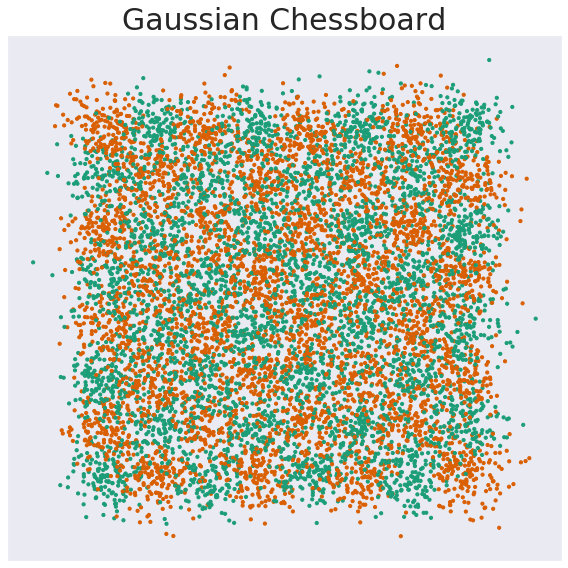

In [44]:
colors = sns.color_palette('Dark2', n_colors=2)

Z, W = generate_gaussian_parity(10000, cov_scale=0.01, angle_params=0, k=3)

fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.scatter(Z[:, 0], Z[:, 1], c=get_colors(colors, W), s=10)

ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Gaussian Chessboard', fontsize=30)

plt.tight_layout()
plt.savefig('figures/gaussian-lifelong-experiments/gaussian-cb.pdf')

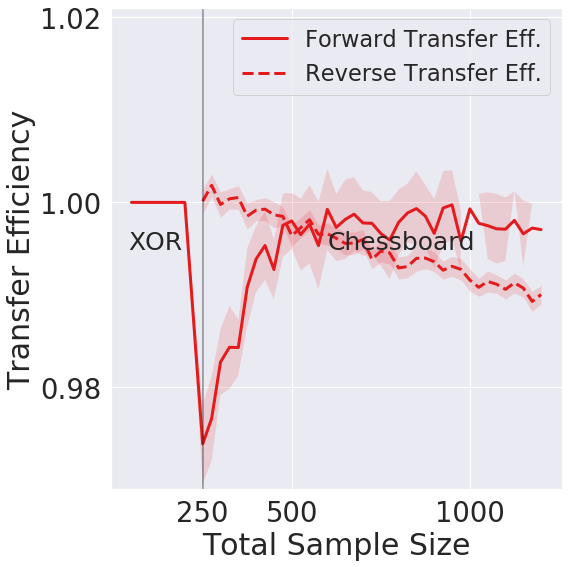

In [45]:
mean_error = mean_te_xor_cb
std_error = std_te_xor_cb / np.sqrt(n_mc)

TASK1='XOR'
TASK2='Chessboard'

colors = sns.color_palette("Set1", n_colors = 2)

fig1 = plt.figure(figsize=(8,8))
ax1 = fig1.add_subplot(1,1,1)

ax1.plot(ns, mean_error[0], label=algorithms[0], c=colors[0], ls=ls[np.sum(0 > 1).astype(int)], lw=3)
ax1.fill_between(ns, 
        mean_error[0] + 1.96*std_error[0], 
        mean_error[0] - 1.96*std_error[0], 
        where=mean_error[1] + 1.96*std_error[0] >= mean_error[0] - 1.96*std_error[0], 
        facecolor=colors[0], 
        alpha=0.15,
        interpolate=True)

ax1.plot(ns[len(n1s):], mean_error[1, len(n1s):], label=algorithms[1], c=colors[0], ls=ls[1], lw=3)
ax1.fill_between(ns[len(n1s):], 
        mean_error[1, len(n1s):] + 1.96*std_error[1, len(n1s):], 
        mean_error[1, len(n1s):] - 1.96*std_error[1, len(n1s):], 
        where=mean_error[1, len(n1s):] + 1.96*std_error[1, len(n1s):] >= mean_error[1, len(n1s):] - 1.96*std_error[1, len(n1s):], 
        facecolor=colors[0], 
        alpha=0.15,
        interpolate=True)

ax1.set_ylabel('Transfer Efficiency', fontsize=fontsize)
ax1.legend(loc='upper right', fontsize=22.5)
#         ax1.set_ylim(-0.01, 0.22)
ax1.set_xlabel('Total Sample Size', fontsize=fontsize)
ax1.tick_params(labelsize=labelsize)
ax1.set_yticks([0.98, 1, 1.02])
ax1.set_xticks([250, 500, 1000])
ax1.axvline(x=ns[len(n1s)], c='k', alpha=0.5)

ax1.set_ylim(0.969, 1.021)

ax1.text(40,  np.mean(ax1.get_ylim()), "%s"%(TASK1), fontsize=25)
ax1.text(600,  np.mean(ax1.get_ylim()), "%s"%(TASK2), fontsize=25)

plt.tight_layout()

plt.savefig('figures/gaussian-lifelong-experiments/lifelong_experiment_te_%s_%s_nmc%i_nD%i_n1%ito%i_n2%ito%i_d%i_m%i.pdf'%(TASK1, TASK2,
                                                                                                   n_mc, nR, n_xor[0],
                                                                                                   n_xor[-1], n_nxor[0],
                                                                                                   n_nxor[-1], d, m))
 

In [46]:
TASK1='Chessboard'
TASK2='XOR'
mean_error_cb_xor = pickle.load(open('data/gaussian-lifelong-experiments/mean_error_%s_%s_nmc%i_nD%i_n1%ito%i_n2%ito%i_d%i_m%i.pkl'%(TASK1, TASK2,
                                                                                                   n_mc, nR, n_xor[0],
                                                                                                   n_xor[-1], n_nxor[0],
                                                                                                   n_nxor[-1], d, m), 
                                      'rb'))

std_error_cb_xor = pickle.load(open('data/gaussian-lifelong-experiments/std_error_%s_%s_nmc%i_nD%i_n1%ito%i_n2%ito%i_d%i_m%i.pkl'%(TASK1, TASK2,
                                                                                                   n_mc, nR, n_xor[0],
                                                                                                   n_xor[-1], n_nxor[0],
                                                                                                   n_nxor[-1], d, m), 
                                      'rb'))

mean_te_cb_xor = pickle.load(open('data/gaussian-lifelong-experiments/mean_te_%s_%s_nmc%i_nD%i_n1%ito%i_n2%ito%i_d%i_m%i.pkl'%(TASK1, TASK2,
                                                                                                   n_mc, nR, n_xor[0],
                                                                                                   n_xor[-1], n_nxor[0],
                                                                                                   n_nxor[-1], d, m), 
                                      'rb'))

std_te_cb_xor = pickle.load(open('data/gaussian-lifelong-experiments/std_te_%s_%s_nmc%i_nD%i_n1%ito%i_n2%ito%i_d%i_m%i.pkl'%(TASK1, TASK2,
                                                                                                   n_mc, nR, n_xor[0],
                                                                                                   n_xor[-1], n_nxor[0],
                                                                                                   n_nxor[-1], d, m), 
                                      'rb'))

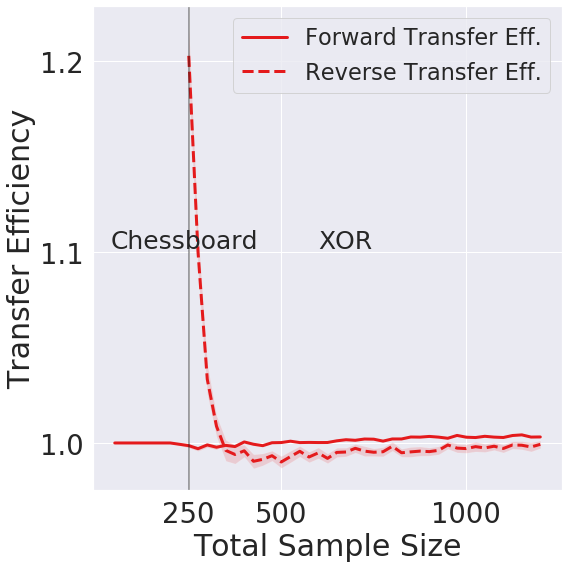

In [47]:
mean_error = mean_te_cb_xor
std_error = std_te_cb_xor / np.sqrt(n_mc)

TASK1='Chessboard'
TASK2='XOR'

fig1 = plt.figure(figsize=(8,8))
ax1 = fig1.add_subplot(1,1,1)

ax1.plot(ns, mean_error[0], label=algorithms[0], c=colors[0], ls=ls[np.sum(0 > 1).astype(int)], lw=3)
ax1.fill_between(ns, 
        mean_error[0] + 1.96*std_error[0], 
        mean_error[0] - 1.96*std_error[0], 
        where=mean_error[1] + 1.96*std_error[0] >= mean_error[0] - 1.96*std_error[0], 
        facecolor=colors[0], 
        alpha=0.15,
        interpolate=True)

ax1.plot(ns[len(n1s):], mean_error[1, len(n1s):], label=algorithms[1], c=colors[0], ls=ls[1], lw=3)
ax1.fill_between(ns[len(n1s):], 
        mean_error[1, len(n1s):] + 1.96*std_error[1, len(n1s):], 
        mean_error[1, len(n1s):] - 1.96*std_error[1, len(n1s):], 
        where=mean_error[1, len(n1s):] + 1.96*std_error[1, len(n1s):] >= mean_error[1, len(n1s):] - 1.96*std_error[1, len(n1s):], 
        facecolor=colors[0], 
        alpha=0.15,
        interpolate=True)

ax1.set_ylabel('Transfer Efficiency', fontsize=fontsize)
ax1.legend(loc='upper right', fontsize=22.5)
#         ax1.set_ylim(-0.01, 0.22)
ax1.set_xlabel('Total Sample Size', fontsize=fontsize)
ax1.tick_params(labelsize=labelsize)
ax1.set_yticks([1, 1.1, 1.2])
ax1.set_xticks([250, 500, 1000])
ax1.axvline(x=ns[len(n1s)], c='k', alpha=0.5)

# ax1.set_ylim(0.99, 1.061)

ax1.text(40,  np.mean(ax1.get_ylim()), "%s"%(TASK1), fontsize=25)
ax1.text(600,  np.mean(ax1.get_ylim()), "%s"%(TASK2), fontsize=25)

plt.tight_layout()

plt.savefig('figures/gaussian-lifelong-experiments/lifelong_experiment_te_%s_%s_nmc%i_nD%i_n1%ito%i_n2%ito%i_d%i_m%i.pdf'%(TASK1, TASK2,
                                                                                                   n_mc, nR, n_xor[0],
                                                                                                   n_xor[-1], n_nxor[0],
                                                                                                   n_nxor[-1], d, m))